# Noisy Learning


In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

In [2]:
def make_simple_plot():
    fig, axes=plt.subplots(figsize=(12,5), nrows=1, ncols=2);
    axes[0].set_ylabel("$y$")
    axes[0].set_xlabel("$x$")
    axes[1].set_xlabel("$x$")
    axes[1].set_yticklabels([])
    axes[0].set_ylim([-2,2])
    axes[1].set_ylim([-2,2])
    plt.tight_layout();
    return axes
def make_plot():
    fig, axes=plt.subplots(figsize=(20,8), nrows=1, ncols=2);
    axes[0].set_ylabel("$p_R$")
    axes[0].set_xlabel("$x$")
    axes[1].set_xlabel("$x$")
    axes[1].set_yticklabels([])
    axes[0].set_ylim([0,1])
    axes[1].set_ylim([0,1])
    axes[0].set_xlim([0,1])
    axes[1].set_xlim([0,1])
    plt.tight_layout();
    return axes

## Revisiting our model

Let us revisit our model from noiseless_learning.

Let $x$ be the fraction of religious people in a county and $y$ be the probability of voting for Romney as a function of $x$. In other words $y_i$ is data that pollsters have taken which tells us their estimate of people voting for Romney and $x_i$ is the fraction of religious people in county $i$. Because poll samples are finite, there is a margin of error on each data point or county $i$, but we will ignore that for now.

Let us assume that we have a "population" of 200 counties $x$:

In [3]:
df=pd.read_csv("data/religion.csv")
df.head()

,promney,rfrac
0,0.047790,0.00
1,0.051199,0.01
2,0.054799,0.02
3,0.058596,0.03
4,0.062597,0.04


Lets suppose now that the Lord came by and told us that the points in the plot below captures $f(x)$ exactly. 

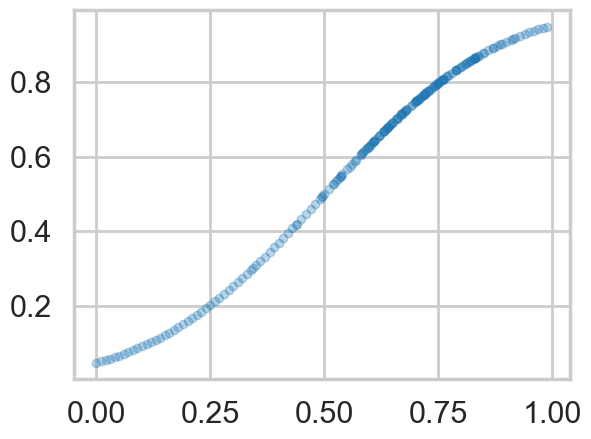

In [4]:
x=df.rfrac.values
f=df.promney.values
plt.plot(x,f,'.', alpha=0.3)

Notice that our sampling of $x$ is not quite uniform: there are more points around $x$ of 0.7.

Now, in real life we are only given a sample of points. Lets assume that out of this population of 200 points we are given a sample $\cal{D}$ of 30 data points. Such data is called **in-sample data**. Contrastingly, the entire population of data points is also called **out-of-sample data**.

In [5]:
dfsample = pd.read_csv("data/noisysample.csv")
indexes=dfsample.i.values

In [6]:
dfpop = pd.read_csv("data/noisypopulation.csv")
dfpop.head()

,f,x,y
0,0.047790,0.00,0.011307
1,0.051199,0.01,0.010000
2,0.054799,0.02,0.007237
3,0.058596,0.03,0.000056
4,0.062597,0.04,0.010000


In [7]:
samplex = x[indexes]
samplef = f[indexes]

<>:4: SyntaxWarning: invalid escape sequence '\c'
<>:4: SyntaxWarning: invalid escape sequence '\c'
/var/folders/td/94qngg4x2_lcb32n6td6t7540000gn/T/ipykernel_25783/191699542.py:4: SyntaxWarning: invalid escape sequence '\c'
  axes[1].plot(samplex,samplef, 's', alpha=0.6, label="in-sample data $\cal{D}$");


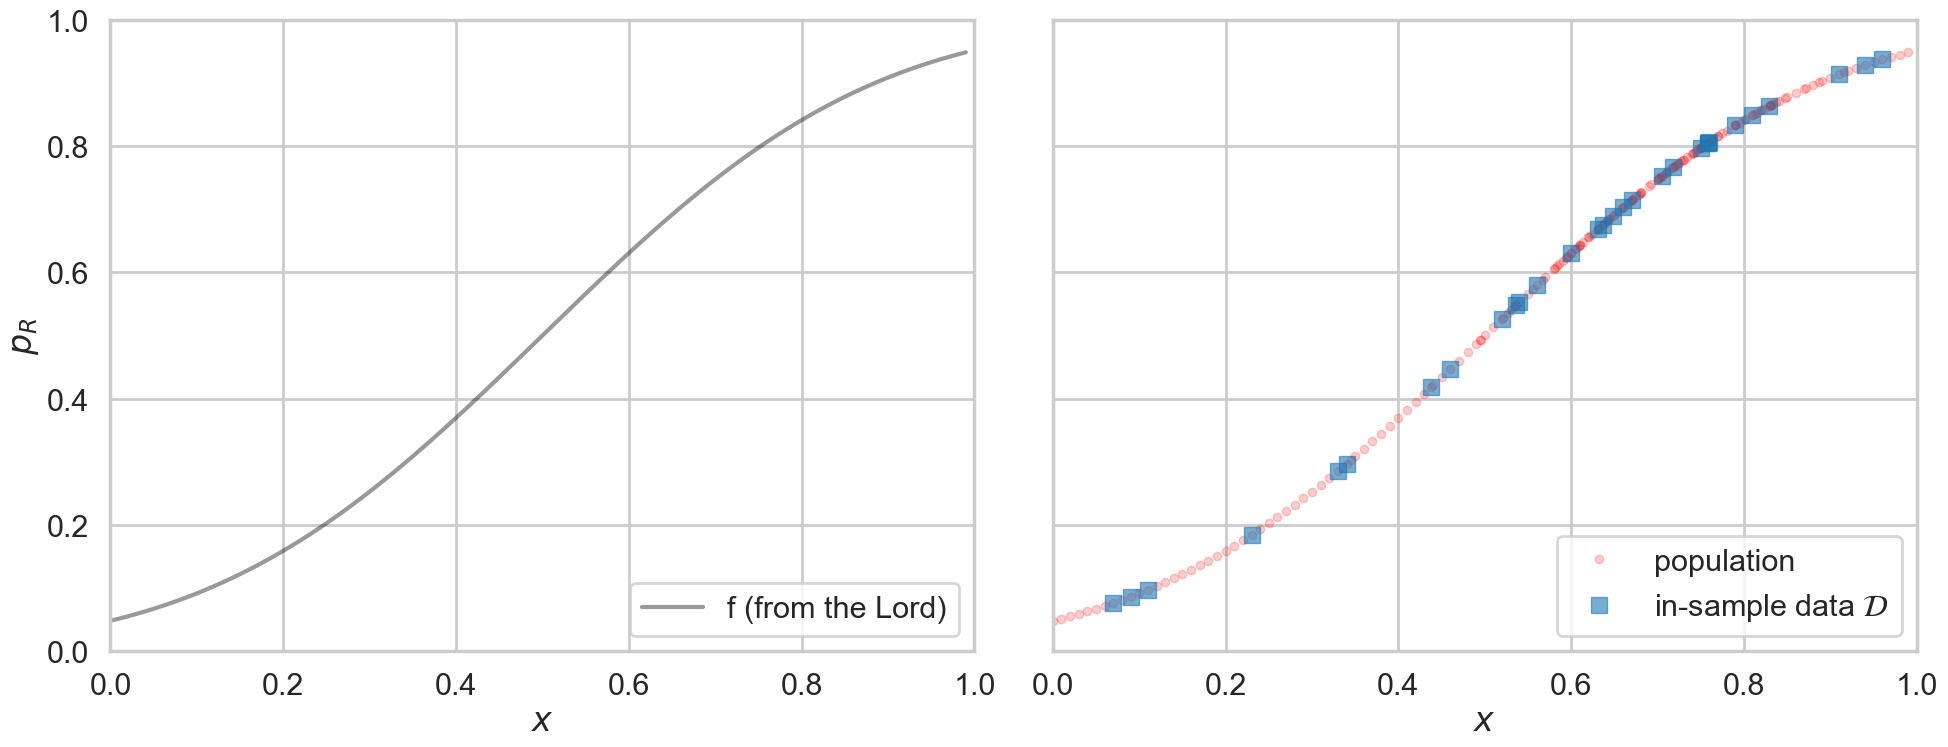

In [8]:
axes=make_plot()
axes[0].plot(x,f, 'k-', alpha=0.4, label="f (from the Lord)");
axes[1].plot(x,f, 'r.', alpha=0.2, label="population");
axes[1].plot(samplex,samplef, 's', alpha=0.6, label="in-sample data $\cal{D}$");
axes[0].legend(loc=4);
axes[1].legend(loc=4);

### Statement of the learning problem.

Let us restate  the learning problem from [noiseless learning](noiseless_learning.html).

If we find a hypothesis $g$ that minimizes the cost or risk over the training set (our sample), this hypothesis *might* do a good job over the population that the training set was representative of, since the risk on the population ought to be similar to that on the training set, and thus small.

Mathematically, we are saying that:

$$
\begin{eqnarray*}
A &:& R_{\cal{D}}(g) \,\,smallest\,on\,\cal{H}\\
B &:& R_{out} (g) \approx R_{\cal{D}}(g)
\end{eqnarray*}
$$

In other words, we hope the **empirical risk estimates the out of sample risk well, and thus the out of sample risk is also small**.

## Why go out-of-sample

Clearly we want tolearn something about a population, a population we dont have access to. So far we have stayed within the constraints of our sample and might want to draw all our conclusions from this sample.

This is a bad idea.

You probably noticed that I used weasel words like "might" and "hope" in the last section when saying that representative sampling in both training and test sets combined with ERM is what we need to learn a model. Let me give you a very simple counterexample: a prefect memorizer.

Suppose I construct a model which memorizes all the data points in the training set. Then its emprical risk is zero by definition, but it has no way of predicting anything on a test set. Thus it might as well choose the value at a new point randomly, and will perform very poorly. The process of interpolating a curve from points is precisely this memorization

### Stochastic Noise

We saw before that $g_{20}$ did a very good job in capturing the curves of the population. However, note that the data obtained from $f$, our target, was still quite smooth. Most real-world data sets are not smooth at all, because of various effects such as measurement errors, other co-variates, and so on. Such **stochastic noise** plays havoc with our fits, as we shall see soon.

Stochastic noise bedevils almost every data set known to humans, and happens for many different reasons. 

Consider for example two customers of a bank with identical credit histories and salaries. One defaults on their mortgage, and the other does not. In this case we have identical $x = (credit, salary)$ for these two customers, but different $y$, which is a variable that is 1 if the customer defaulted and 0 otherwise. The true $y$ here might be a function of other co-variates, such as marital strife, sickness of parents, etc. But, as the bank, we might not have this information. So we get different $y$ for different customers at the information $x$ that we possess.

A similar thing might be happen in the election example, where we have modelled the probability of voting for romney as a function of religiousness of the county. There are many other variables we might not have measured, such as the majority race in that county.  But, we have not measured this information. Thus, in counties with high religiousness fraction $x$ we might have more noise than in others. Consider for example two counties, one with $x=0.8$ fraction of self-identified religious people in the county, and another with $x=0.82$. Based on historical trends, if the first county was mostly white, the fraction of those claiming they would vote for Romney might be larger than in a second, mostly black county. Thus you might have two very $y$'s next to each other on our graphs.

It gets worse. When pollsters estimate the number of people voting for a particular candidate, they only use finite samples of voters. So there is a 4-6\% polling error in any of these estimates. This "sampling noise" adds to the noisiness of the $y$'s. 


Indeed, we wish to estimate a function $f(x)$ so that the values $y_i$ come from the function $f$. Since we are trying to estimate f with data from only some counties, and furthermore, our estimates of the population behaviour in these counties will be noisy, our estimate wont be the "god given" or "real" f, but rather some **noisy** estimate of it. 



In [9]:
dfsample.head()

,f,i,x,y
0,0.075881,7,0.07,0.138973
1,0.085865,9,0.09,0.050510
2,0.096800,11,0.11,0.183821
3,0.184060,23,0.23,0.057621
4,0.285470,33,0.33,0.358174


In [10]:
dfsample.shape

(30, 4)

In [11]:
x = dfpop.x.values
f = dfpop.f.values
y = dfpop.y.values

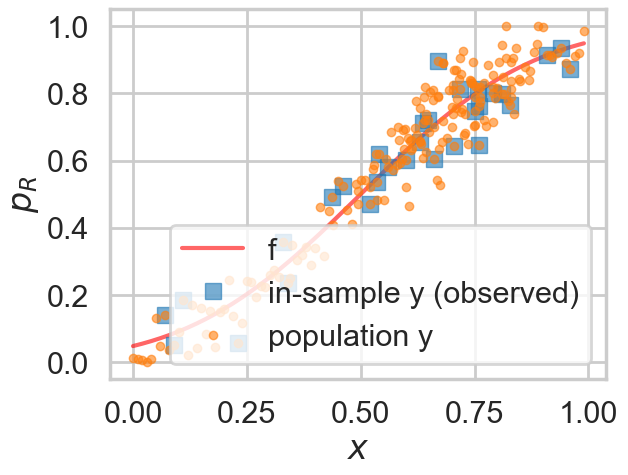

In [12]:
plt.plot(x,f, 'r-', alpha=0.6, label="f");
plt.plot(x[indexes], y[indexes], 's', alpha=0.6, label="in-sample y (observed)");
plt.plot(x, y, '.', alpha=0.6, label="population y");
plt.xlabel('$x$');
plt.ylabel('$p_R$')
plt.legend(loc=4);

In the figure above, one can see the scatter of the $y$ population about the curve of $f$. The errors of the 30 observation points ("in-sample") are shown as squares. One can see that observations next to each other can now be fairly different, as we descibed above.

## Fitting a noisy model

Let us now try and fit the noisy data we simulated above, both using straight lines ($\cal{H_1}$), and 20th order polynomials($\cal{H_{20}}$). 

What we have done is introduced a noisy target $y$, so that

$$y = f(x) + \epsilon\,,$$

where $\epsilon$ is a **random** noise term that represents the stochastic noise. 

### Describing things probabilistically

Another way to think about a noisy $y$ is to imagine that our data is generated from a joint probability distribution $P(x,y)$. In our earlier case with no stochastic noise, once you knew $x$, if I were to give you $f(x)$, you could give me $y$ exactly. This is now not possible because of the noise $\epsilon$: we dont know exactly how much noise we have at any given $x$. Thus we need to model $y$ at a given $x$, $P(y \mid x)$, as well using a probability distribution. Since $P(x)$ is also a probability distribution, we have:

$$P(x,y) = P(y \mid x) P(x) .$$

![](images/NoisyModelPxy.png)

Now the entire learning problem can be cast as a problem in probability **density estimation**: if we can estimate $P(x,y)$ and take actions based on that estimate thanks to our risk or error functional, we are done. 

We now fit in both $\cal{H_1}$ and $\cal{H_{20}}$ to find the best fit straight line and best fit 20th order polynomial respectively.

In [13]:
g1 = np.poly1d(np.polyfit(x[indexes],f[indexes],1))
g20 = np.poly1d(np.polyfit(x[indexes],f[indexes],20))

/var/folders/td/94qngg4x2_lcb32n6td6t7540000gn/T/ipykernel_25783/2024862568.py:2: RankWarning: Polyfit may be poorly conditioned
  g20 = np.poly1d(np.polyfit(x[indexes],f[indexes],20))


In [14]:
g1noisy = np.poly1d(np.polyfit(x[indexes],y[indexes],1))
g20noisy = np.poly1d(np.polyfit(x[indexes],y[indexes],20))

/var/folders/td/94qngg4x2_lcb32n6td6t7540000gn/T/ipykernel_25783/3327932717.py:2: RankWarning: Polyfit may be poorly conditioned
  g20noisy = np.poly1d(np.polyfit(x[indexes],y[indexes],20))


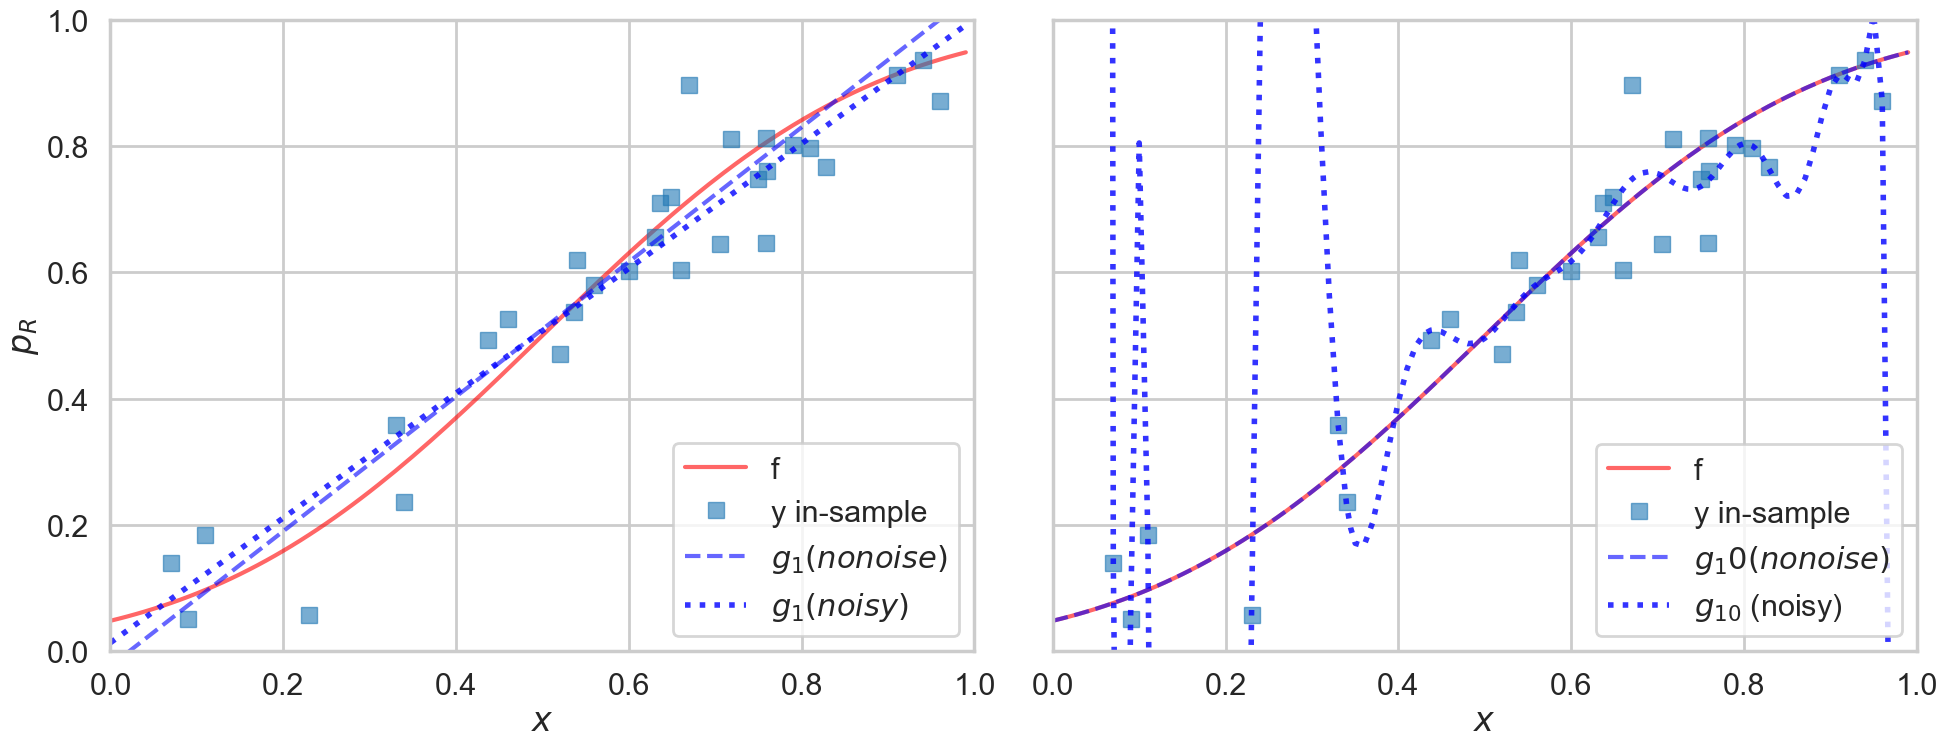

In [15]:
axes=make_plot()
axes[0].plot(x,f, 'r-', alpha=0.6, label="f");
axes[1].plot(x,f, 'r-', alpha=0.6, label="f");
axes[0].plot(x[indexes],y[indexes], 's', alpha=0.6, label="y in-sample");
axes[1].plot(x[indexes],y[indexes], 's', alpha=0.6, label="y in-sample");
axes[0].plot(x,g1(x),  'b--', alpha=0.6, label="$g_1 (no noise)$");
axes[0].plot(x,g1noisy(x), 'b:', lw=4, alpha=0.8, label="$g_1 (noisy)$");
axes[1].plot(x,g20(x),  'b--', alpha=0.6, label="$g_10 (no noise)$");
axes[1].plot(x,g20noisy(x), 'b:', lw=4, alpha=0.8, label="$g_{10}$ (noisy)");
axes[0].legend(loc=4);
axes[1].legend(loc=4);

The results are (to put it mildly) very interesting. 

Lets look at the figure on the left first. The noise changes the best fit line by a little but not by much. The best fit line still does a very poor job of capturing the variation in the data.

The best fit 20th order polynomial, in the presence of noise, is very interesting. It tries to follow all the curves of the observations..in other words, it tries to fit the noise. This is a disaster, as you can see if you plot the population (out-of-sample) points on the plot as well:

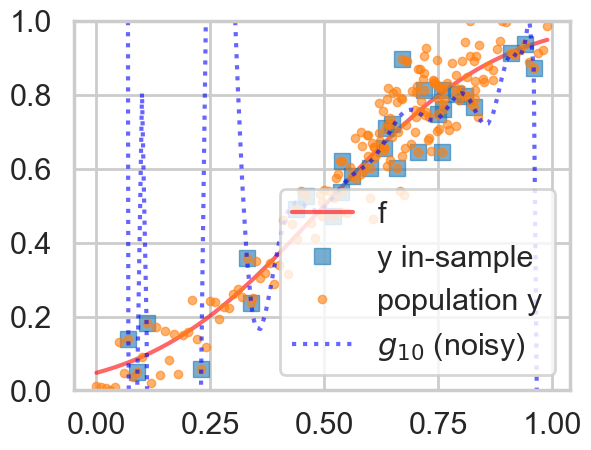

In [16]:
plt.plot(x,f, 'r-', alpha=0.6, label="f");
plt.plot(x[indexes],y[indexes], 's', alpha=0.6, label="y in-sample");
plt.plot(x,y,  '.', alpha=0.6, label="population y");
plt.plot(x,g20noisy(x), 'b:', alpha=0.6, label="$g_{10}$ (noisy)");
plt.ylim([0,1])
plt.legend(loc=4);

Whoa. The best-fit 20th order polynomial does a reasonable job fitting the in-sample data, and is even well behaved in the middle where we have a lot of in-sample data points. But at places with less in-sample data points, the polynomial wiggles maniacally.

This fitting to the noise is a danger you will encounter again and again in learning. Its called **overfitting**. So, $\cal{H_{20}}$ which seemed to be such a good candidate hypothesis space in the absence of noise, ceases to be one. The take away lesson from this is that we must further ensure that our **model does not fit the noise**.

Lets make a plot similar to the one we made for the deterministic noise earlier, and compare the error in the new $g_1$ and $g_{20}$ fits on the noisy data.

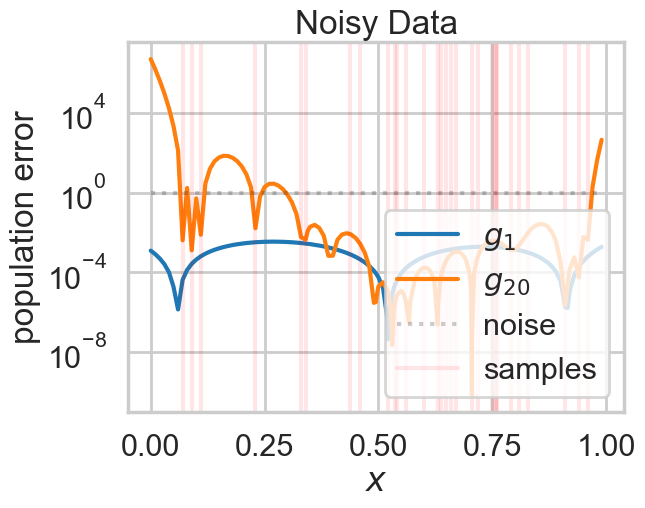

In [17]:
plt.plot(x, ((g1noisy(x)-f)**2), lw=3, label="$g_1$")
plt.plot(x, ((g20noisy(x)-f)**2), lw=3,label="$g_{20}$");
plt.plot(x, [1]*x.shape[0], "k:", label="noise", alpha=0.2);
for i in indexes[:-1]:
    plt.axvline(x[i], 0, 1, color='r', alpha=0.1)
plt.axvline(x[indexes[-1]], 0, 1, color='r', alpha=0.1, label="samples")
plt.xlabel("$x$")
plt.ylabel("population error")
plt.yscale("log")
plt.legend(loc=4);
plt.title("Noisy Data");

$g_1$ now, for the most part, has a lower error! So you'd be better off by having chosen a set of models with much more bias (the straight lines, $\cal{H}_1$) than a more complex model set ($\cal{H}_{20}$) in the case of noisy data. 

### The Variance of your model

This tendency of a more complex model to overfit, by having enough freedom to fit the noise, is described by something called high **variance**. What is variance?

Variance, simply put, is the "error-bar" or spread in models that would be learnt by training on different data sets $\cal{D_1}, \cal{D_2},...$ drawn from the population. Now, this seems like a circular concept, as in real-life, you do not have access to the population. But since we simulated our data here anyways, we do, and so let us see what happens if we choose **different 30 points randomly from our population of 200**, and fit models in both $\cal{H_1}$ and $\cal{H_{20}}$ to them. We do this on 200 sets of randomly chosen (from the population) data sets of 30 points each and plot the best fit models in noth hypothesis spaces for all 200 sets.

In [18]:
def gen(degree, nsims, size, x, out):
    outpoly=[]
    for i in range(nsims):
        indexes=np.sort(np.random.choice(x.shape[0], size=size, replace=False))
        pc=np.polyfit(x[indexes], out[indexes], degree)
        p=np.poly1d(pc)
        outpoly.append(p)
    return outpoly

In [19]:
polys1 = gen(1, 200, 30,x, y);
polys20 = gen(20, 200, 30,x, y);

/var/folders/td/94qngg4x2_lcb32n6td6t7540000gn/T/ipykernel_25783/2389033383.py:5: RankWarning: Polyfit may be poorly conditioned
  pc=np.polyfit(x[indexes], out[indexes], degree)
/var/folders/td/94qngg4x2_lcb32n6td6t7540000gn/T/ipykernel_25783/2389033383.py:5: RankWarning: Polyfit may be poorly conditioned
  pc=np.polyfit(x[indexes], out[indexes], degree)
/var/folders/td/94qngg4x2_lcb32n6td6t7540000gn/T/ipykernel_25783/2389033383.py:5: RankWarning: Polyfit may be poorly conditioned
  pc=np.polyfit(x[indexes], out[indexes], degree)
/var/folders/td/94qngg4x2_lcb32n6td6t7540000gn/T/ipykernel_25783/2389033383.py:5: RankWarning: Polyfit may be poorly conditioned
  pc=np.polyfit(x[indexes], out[indexes], degree)
/var/folders/td/94qngg4x2_lcb32n6td6t7540000gn/T/ipykernel_25783/2389033383.py:5: RankWarning: Polyfit may be poorly conditioned
  pc=np.polyfit(x[indexes], out[indexes], degree)
/var/folders/td/94qngg4x2_lcb32n6td6t7540000gn/T/ipykernel_25783/2389033383.py:5: RankWarning: Polyfit ma

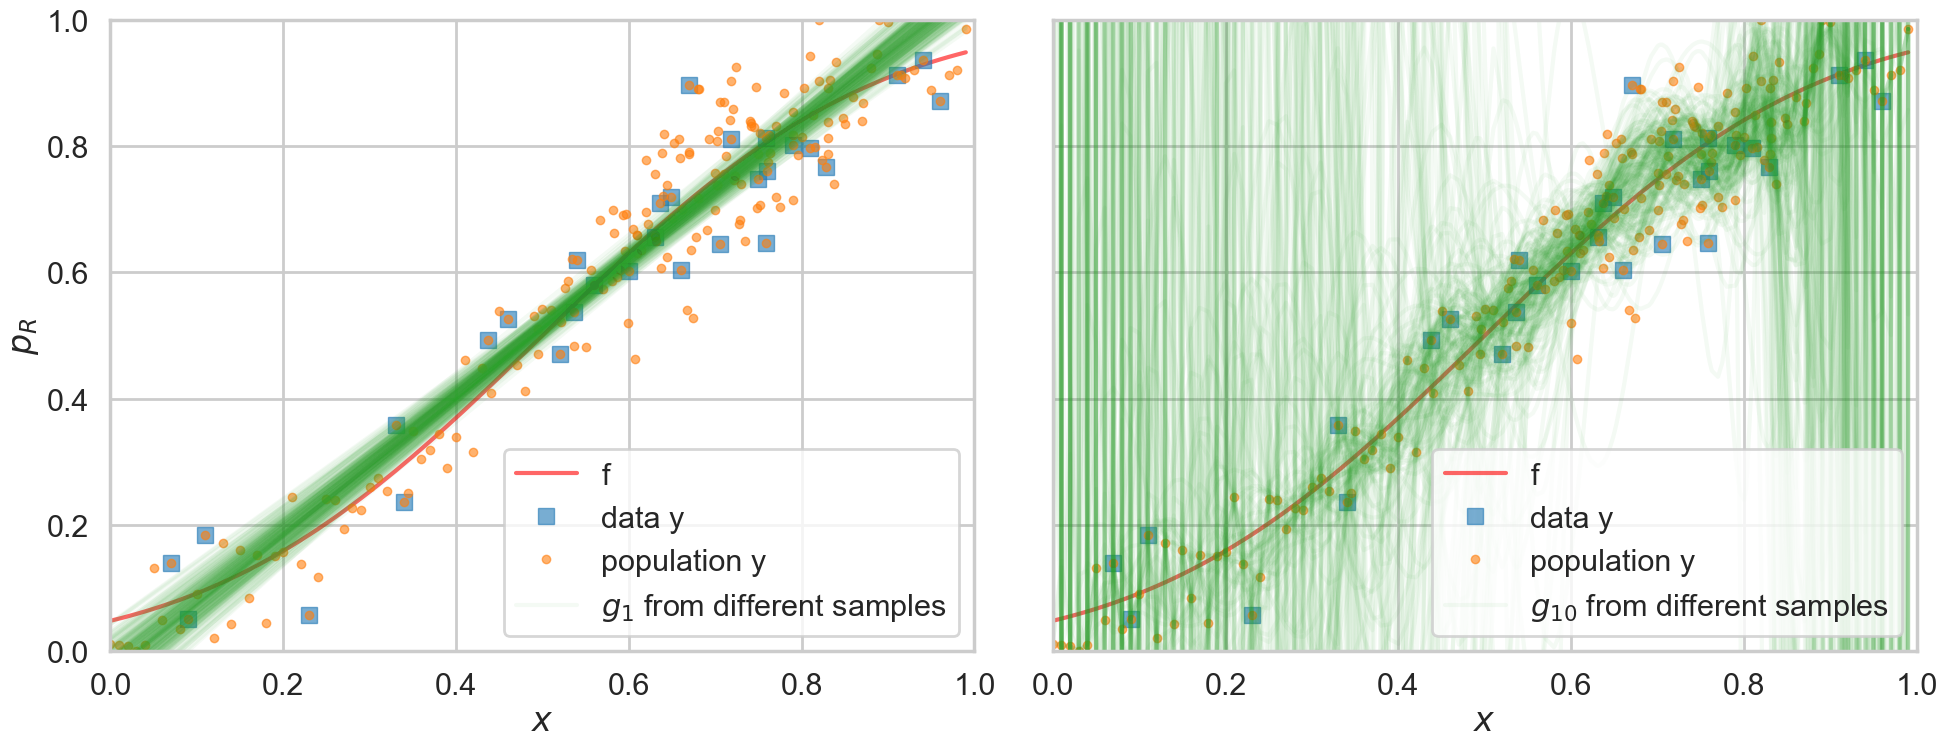

In [20]:
axes=make_plot()
axes[0].plot(x,f, 'r-', lw=3, alpha=0.6, label="f");
axes[1].plot(x,f, 'r-', lw=3, alpha=0.6, label="f");
axes[0].plot(x[indexes], y[indexes], 's', alpha=0.6, label="data y");
axes[1].plot(x[indexes], y[indexes], 's', alpha=0.6, label="data y");
axes[0].plot(x, y, '.', alpha=0.6, label="population y");
axes[1].plot(x, y, '.', alpha=0.6, label="population y");
c=sns.color_palette()[2]
for i,p in enumerate(polys1[:-1]):
    axes[0].plot(x,p(x), alpha=0.05, c=c)
axes[0].plot(x,polys1[-1](x), alpha=0.05, c=c,label="$g_1$ from different samples")
for i,p in enumerate(polys20[:-1]):
    axes[1].plot(x,p(x), alpha=0.05, c=c)
axes[1].plot(x,polys20[-1](x), alpha=0.05, c=c, label="$g_{10}$ from different samples")
axes[0].legend(loc=4);
axes[1].legend(loc=4);

On the left panel, you see the 200 best fit straight lines, each a fit on a different 30 point training sets from the 200 point population. The best-fit lines bunch together, even if they dont quite capture $f$ (the thick red line) or the data (squares) terribly well.

On the right panel, we see the same with best-fit models chosen from $\cal{H}_{20}$. It is a diaster. While most of the models still band around the central trend of the real curve $f$ and data $y$ (and you still see the waves corresponding to all too wiggly 20th order polynomials), a substantial amount of models veer off into all kinds of noisy hair all over the plot. This is **variance**: the the predictions at any given $x$ are all over the place.

The variance can be seen in a different way by plotting the coefficients of the polynomial fit. Below we plot the coefficients of the fit in $\cal{H}_1$. The variance is barely 0.2 about the mean for both co-efficients.

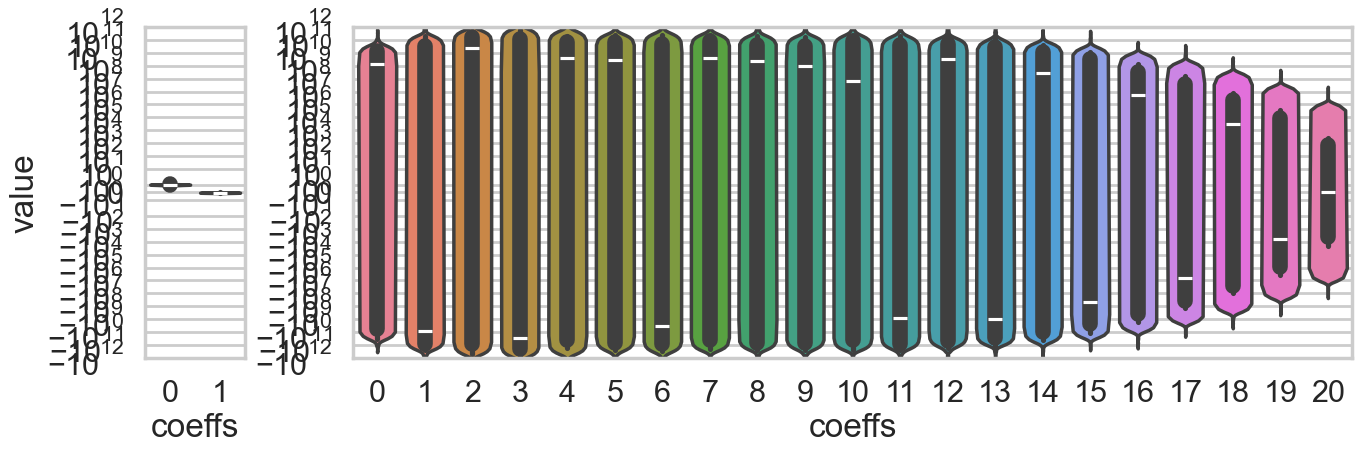

In [21]:
pdict1={}
pdict20={}
for i in reversed(range(2)):
    pdict1[i]=[]
    for j, p in enumerate(polys1):
        pdict1[i].append(p.c[i])
for i in reversed(range(21)):
    pdict20[i]=[]
    for j, p in enumerate(polys20):
        pdict20[i].append(p.c[i]) 
df1=pd.DataFrame(pdict1)
df20=pd.DataFrame(pdict20)
fig = plt.figure(figsize=(14, 5)) 
from matplotlib import gridspec
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 10]) 
axes = [plt.subplot(gs[0]), plt.subplot(gs[1])]
axes[0].set_ylabel("value")
axes[0].set_xlabel("coeffs")
axes[1].set_xlabel("coeffs")
plt.tight_layout();
sns.violinplot(df1, ax=axes[0]);
sns.violinplot(df20, ax=axes[1]);
axes[0].set_yscale("symlog");
axes[1].set_yscale("symlog");
axes[0].set_ylim([-1e12, 1e12]);
axes[1].set_ylim([-1e12, 1e12]);

In the right panel we plot the coefficients of the fit in $\cal{H}_{20}$. This is why we use the word "variance": the spread in the values of the middle coefficients about their means (dashed lines) is of the order $10^{10}$ (the vertical height of the bulges), with huge outliers!! The 20th order polynomial fits are a disaster!

## Bias and Variance

We have so far informally described two different concepts: bias and variance. Bias is deterministic error, the kind of error you get when your model is not expressive enough to describe the data. Variance describes the opposite problem, where it is too expressive.

Every model has some bias and some variance. Clearly, you dont want either to dominate, which is something we'll worry about soon.

Let us mathematically understand what bias and variance are, so that we can use these terms more precisely from now onwards. Follow carefully to see how our calculation mimics the code/process we used above.

$$\renewcommand{\gcald}{g_{\cal D}}$$
$$\renewcommand{\ecald}{E_{\cal{D}}}$$

We had from [noiseless learning](noiseless_learning.html):

$$R_{out}(h) =  E_{p(x)}[(h(x) - f(x))^2] = \int dx p(x)  (h(x) - f(x))^2 .$$

In the presence of noise $\epsilon$ which we shall assume to be 0-mean, variance $\sigma^2$ noise, we have $y = f(x) + \epsilon$ and the above formula becomes:

$$R_{out}(h) =  E_{p(x)}[(h(x) - y)^2] = \int dx p(x)  (h(x) - f(x) - \epsilon)^2 .$$

Now let us use Empirical Risk minimization to fit on our training set. We come up with a best fit hypothesis $h = \gcald$, where $\cal{D}$ is our training sample.

$$R_{out}(\gcald) =  E_{p(x)}[(\gcald(x) - f(x) - \epsilon)^2] $$

Let us compute the expectation of this quantity with respect to the sampling distribution obtained by choosing different samples from the population. Note that we cant really do this if we have been only given one training set, but in this document, we have had access to the population and can thus experiment.

Define:

$$\langle  R \rangle = E_{\cal{D}} [R_{out}(\gcald)] =  E_{\cal{D}}E_{p(x)}[(\gcald(x) - f(x) - \epsilon)^2] $$

$$
\begin{eqnarray*}
=& E_{p(x)}\ecald[(\gcald(x) - f(x) - \epsilon)^2]\\
=& E_{p(x)}[\ecald[\gcald^2] +  f^2 + \epsilon^2 - 2\,f\,\ecald[\gcald]]
\end{eqnarray*}
$$

Define:

$$ \bar{g} = \ecald[\gcald] = (1/M)\sum_{\cal{D}} \gcald$$

as the average "g" over all the fits (M of them) on the different samples, so that we can write, adding and subtracting $\bar{g}^2$:

$$\langle  R \rangle =  E_{p(x)}[\ecald[\gcald^2] - \bar{g}^2 +  f^2 - 2\,f\,\bar{g} + \bar{g}^2 + \epsilon^2 ] = E_{p(x)}[\ecald[(\gcald - \bar{g})^2]  +  (f - \bar{g})^2 + \epsilon^2 ]$$

Thus:

$$\langle  R \rangle =  E_{p(x)}[\ecald[(\gcald - \bar{g})^2]] + E_{p(x)}[(f - \bar{g})^2] + \sigma^2$$

The first term here is called the **variance**, and captures the squared error of the various fit g's from the average g, or in other words, the hairiness. The second term is called the **bias**, and tells us, how far the average g is from the original f this data came from. Finally the third term is the **stochastic noise**, the minimum error that this model will always have.

Note that if we set the stochastic noise to 0 we get back the noiseless model we started out with. So even in a noiseless model, we do have bias and variance. This is because we still have sampling noise in such a model, and this is one of the sources of variance.

## So far?

- you have learnt the basic formulation of the learning problem, the concept of a hypothesis space, and a strategy using minimization of distance (called cost or risk) to find the best fit model for the target function from this hypothesis space. 
- You learned the effect of noise on this fit, and the issues that crop up in learning target functions from data, chiefly the problem of overfitting to this noise. 


The process of learning has two parts:

1. Fit for a model by minimizing the in-sample risk
2. Hope that the in-sample risk approximates the out-of-sample risk well.

Mathematically, we are saying that:

$$
\begin{eqnarray*}
A &:& R_{\cal{D}}(g) \,\,smallest\,on\,\cal{H}\\
B &:& R_{out} (g) \approx R_{\cal{D}}(g)
\end{eqnarray*}
$$


Well, we are scientists. Just hoping does not befit us. But we only have a sample. What are we to do? We can model the in-sample risk and out-of-sample risk. And we can use a test set to estimate our out of sample risk, as we see [here](testingtraining.html).